# <center> Rendu 1 </center>
## <center> Philippa Payne </center>


---


## <center> Partie 1 : Pré-traitement et visualisation </center>


---


### 1.1 Chargez votre jeu de données et affichez un aperçu du tableau.

Commentez brièvement vos données.

In [254]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, completeness_score

plt.rcParams['figure.figsize'] = [12, 12]

file_path = "tmdb_tv_dataset.csv"
data = pd.read_csv(file_path)

# Here I select a sample of 1000 from the dataset to ensure that the following calculations are more efficient:
unfiltered_sample = resample(data, n_samples=3000, replace=False)

# From the selected sample I look to see if any classes of the target variable are represented less than 4 times and then filter out those individuals:
count = unfiltered_sample['status'].value_counts()
classes = count[count >= 4].index

# I create a copy of the data frame to avoid the SettingWithCopyWarning later on:
sample = unfiltered_sample[unfiltered_sample['status'].isin(classes)].copy()

sample

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,...,tagline,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time
68957,72139,The Victorious,1,0,ar,0,0.00,NaN,False,NaN,...,NaN,NaN,NaN,ar,NaN,NaN,العربية,NaN,NaN,0
109987,52995,Peun See Long Hon,0,0,en,0,0.00,NaN,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
34004,97332,Zio Gianni,2,61,it,2,5.75,NaN,False,/qg11ZkLDMwEHj4tEHlSJ3B2qEZp.jpg,...,NaN,Comedy,"Matteo Rovere, Sydney Sibilia, Luca Vecchi, Ma...",it,Rai 2,IT,Italiano,"Ascent Film, RAI",Italy,8
32505,106667,N'oubliez pas les paroles - Primes événementiels,13,47,fr,2,7.20,NaN,False,/lYrPKf4j4oPOosbnG155nJXms24.jpg,...,NaN,Reality,Jeff Apploff,fr,France 2,FR,Français,Air Productions,France,120
41410,55869,Bill Bailey's Jungle Hero,1,2,en,1,8.00,Bill meets wildlife in Borneo and Indonesia to...,False,/oDN3ChXsHFN5BIbGz0wuaK4qL5N.jpg,...,NaN,Documentary,NaN,en,BBC Two,GB,English,NaN,United Kingdom,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142812,232261,煮东煮西,1,1,zh,0,0.00,NaN,False,NaN,...,NaN,Reality,NaN,NaN,NaN,CN,NaN,NaN,NaN,0
114549,21018,Mirakkel,0,0,bn,0,0.00,Mirakkel is an Indian Reality Show on Zee Bang...,False,NaN,...,NaN,Reality,NaN,bn,NaN,IN,বাংলা,NaN,NaN,60
76214,208928,NHK Academia,1,1,ja,0,0.00,A lecture program where leading figures from v...,False,/oQilv6N0vYI4sG91S928zs4IJMl.jpg,...,NaN,Talk,NaN,ja,NHK Educational TV,JP,日本語,NHK,NaN,0
28788,116684,Les documents interdits,1,13,fr,2,7.00,NaN,False,/bHBhF9sSSS7hcvTmZGVDtKGGupP.jpg,...,NaN,NaN,Jean-Teddy Filippe,fr,Arte,FR,Français,NaN,NaN,0


#### _Comments:_

_We can already see that there are several variables that are not useful in terms of this task:_

- _The ID column here is superfluous given that each individual is given a unique ID anyway._
- _Categorical variables representing textual data about each series is irrelevant, particularly any information relevant to paths to images (etc.)._
- _There are clearly several variables representing the language of the series, so it may be best to choose one of these variables so as not to give undue weight to language._
- _Several values contain a list, for example, genre, production company, (etc.) which should be separated in separate columns as dummy variables._
- _The creators for each series vary widely and are therefore not useful a classification or clustering task._
- _There are a lot of NaNs in the dataset, so it would be wise to increase the sample before any filtering operations on it._
- _First and last air date could be complicated to work with, so it might be useful to create a new column with just the first and last air year for these purposes._
- _Any remaining categorical variables must be recoded as as "onehot", such as the type or original language._
- _Any binary variables must be recoded as 0 and 1 rather than False and True._
- _Our target variable, "status" has 5 unique values: "Ended", "Returning Series", "Canceled", "In Production", "Planned" and "Pilot"._

### 1.2 Sélectionnez une des variables catégorielles qui sera la variable à prédire.

Si c’est possible, essayez de choisir une variable qui vous intéresse particulièrement et motivez ce choix.

In [255]:
outputs = sample["status"]

outputs

68957                Ended
109987               Ended
34004                Ended
32505     Returning Series
41410                Ended
                ...       
142812    Returning Series
114549               Ended
76214     Returning Series
28788                Ended
70687                Ended
Name: status, Length: 3000, dtype: object

### 1.3 Traitez les éventuelles valeurs manquantes.

S’il s’agit de la variable à prédire, éliminer toute la ligne. S’il s’agit d’une variable numérique, remplacez-la par sa valeur moyenne. S’il s’agit d’une variable catégorielle ou ordinale, remplacez-la par la modalité la plus fréquente.

In [256]:
# We drop any lines that do not have a value for status, the target variable:
sample.dropna(subset=["status"], inplace=True)

# We loop through each column and fill out any values in the non-target variables accordingly:
for column in sample:
  if sample[column].dtype == "int64":
    sample[column].fillna(sample[column].mean(), inplace=True)
  if sample[column].dtype == "object":
    sample[column].fillna(sample[column].mode()[0], inplace=True)
  # If the column is of data type boolean then we want to recode it as an integer (0 or 1):
  if sample[column].dtype == "bool":
    sample[column] = sample[column].astype(int)

sample


,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,...,tagline,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time
68957,72139,The Victorious,1,0,ar,0,0.00,"""Arrested"" is a shocking documentary series, w...",0,/120vl68cu6XKHtUqTGm2Fs1Wih3.jpg,...,"""In a wooden place, everyone plays together!""",Documentary,Antônio Calmon,ar,BBC One,US,العربية,TVB,United States of America,0
109987,52995,Peun See Long Hon,0,0,en,0,0.00,"""Arrested"" is a shocking documentary series, w...",0,/120vl68cu6XKHtUqTGm2Fs1Wih3.jpg,...,"""In a wooden place, everyone plays together!""",Documentary,Antônio Calmon,en,BBC One,US,English,TVB,United States of America,0
34004,97332,Zio Gianni,2,61,it,2,5.75,"""Arrested"" is a shocking documentary series, w...",0,/qg11ZkLDMwEHj4tEHlSJ3B2qEZp.jpg,...,"""In a wooden place, everyone plays together!""",Comedy,"Matteo Rovere, Sydney Sibilia, Luca Vecchi, Ma...",it,Rai 2,IT,Italiano,"Ascent Film, RAI",Italy,8
32505,106667,N'oubliez pas les paroles - Primes événementiels,13,47,fr,2,7.20,"""Arrested"" is a shocking documentary series, w...",0,/lYrPKf4j4oPOosbnG155nJXms24.jpg,...,"""In a wooden place, everyone plays together!""",Reality,Jeff Apploff,fr,France 2,FR,Français,Air Productions,France,120
41410,55869,Bill Bailey's Jungle Hero,1,2,en,1,8.00,Bill meets wildlife in Borneo and Indonesia to...,0,/oDN3ChXsHFN5BIbGz0wuaK4qL5N.jpg,...,"""In a wooden place, everyone plays together!""",Documentary,Antônio Calmon,en,BBC Two,GB,English,TVB,United Kingdom,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142812,232261,煮东煮西,1,1,zh,0,0.00,"""Arrested"" is a shocking documentary series, w...",0,/120vl68cu6XKHtUqTGm2Fs1Wih3.jpg,...,"""In a wooden place, everyone plays together!""",Reality,Antônio Calmon,en,BBC One,CN,English,TVB,United States of America,0
114549,21018,Mirakkel,0,0,bn,0,0.00,Mirakkel is an Indian Reality Show on Zee Bang...,0,/120vl68cu6XKHtUqTGm2Fs1Wih3.jpg,...,"""In a wooden place, everyone plays together!""",Reality,Antônio Calmon,bn,BBC One,IN,বাংলা,TVB,United States of America,60
76214,208928,NHK Academia,1,1,ja,0,0.00,A lecture program where leading figures from v...,0,/oQilv6N0vYI4sG91S928zs4IJMl.jpg,...,"""In a wooden place, everyone plays together!""",Talk,Antônio Calmon,ja,NHK Educational TV,JP,日本語,NHK,United States of America,0
28788,116684,Les documents interdits,1,13,fr,2,7.00,"""Arrested"" is a shocking documentary series, w...",0,/bHBhF9sSSS7hcvTmZGVDtKGGupP.jpg,...,"""In a wooden place, everyone plays together!""",Documentary,Jean-Teddy Filippe,fr,Arte,FR,Français,TVB,United States of America,0


### 1.4 Éliminez les variables qui vous semblent non pertinentes pour prédire la variable catégorielle.

Si vous possédez d’autre variables catégorielles, transformez-les en variables "one-hot" en supprimant une des modalités. Les variables ordinales doivent être transformées en nombre entiers.

In [257]:
# Here we create two new columns representing the first and last air year to simplify this data:
sample['first_air_year'] = pd.to_datetime(sample['first_air_date'], dayfirst=True).dt.year
sample['last_air_year'] = pd.to_datetime(sample['last_air_date'], dayfirst=True).dt.year

# We create dummy variables for any columns with lists of values:
genre_dummies = sample['genres'].str.get_dummies(', ')
network_dummies = sample['networks'].str.get_dummies(', ')
company_dummies = sample['production_companies'].str.get_dummies(', ')
country_dummies = sample['production_countries'].str.get_dummies(', ')

# We drop any columns that are judged irrelevant to this task:
data = sample.drop(["origin_country", "created_by", "spoken_languages", "languages", "id", "networks", "production_companies", "production_countries", "genres", "name", "first_air_date", "last_air_date", "overview", "backdrop_path", "tagline", "original_name", "poster_path", "homepage"], axis=1)

# Any remaining categorical variables are also encoded with onehot, with integer datatype to get the final data frame:
onehot = pd.get_dummies(data, columns=["original_language", "type"], drop_first=True, dtype=int)

# For some reasons some columns are added twice so I remove the repeated columns here too:
pre_inputs = pd.concat([data.drop(["original_language", "type", 'number_of_seasons', 'number_of_episodes', 'vote_count', 'vote_average', 'adult', 'in_production', 'popularity', 'status', 'episode_run_time', 'first_air_year', 'last_air_year',], axis=1), onehot, genre_dummies], axis=1)

pre_inputs

,number_of_seasons,number_of_episodes,vote_count,vote_average,adult,in_production,popularity,status,episode_run_time,first_air_year,...,Music,Mystery,News,Reality,Romance,Sci-Fi & Fantasy,Soap,Talk,War & Politics,Western
68957,1,0,0,0.00,0,0,0.600,Ended,0,1997,...,0,0,0,0,0,0,0,0,0,0
109987,0,0,0,0.00,0,0,0.600,Ended,0,1997,...,0,0,0,0,0,0,0,0,0,0
34004,2,61,2,5.75,0,0,7.698,Ended,8,2014,...,0,0,0,0,0,0,0,0,0,0
32505,13,47,2,7.20,0,1,12.754,Returning Series,120,2008,...,0,0,0,1,0,0,0,0,0,0
41410,1,2,1,8.00,0,0,1.206,Ended,60,2013,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142812,1,1,0,0.00,0,1,0.600,Returning Series,0,2023,...,0,0,0,1,0,0,0,0,0,0
114549,0,0,0,0.00,0,0,0.600,Ended,60,1997,...,0,0,0,1,0,0,0,0,0,0
76214,1,1,0,0.00,0,1,0.600,Returning Series,0,2022,...,0,0,0,0,0,0,0,1,0,0
28788,1,13,2,7.00,0,0,1.276,Ended,0,1989,...,0,0,0,0,0,0,0,0,0,0


### 1.5 Standardisez toutes vos variables d’entrées.

In [258]:
inputs = StandardScaler().fit_transform(pre_inputs.drop(["status"], axis=1))

pd.DataFrame(inputs)

,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,-0.185909,-0.193817,-0.094320,-0.696210,-0.119159,-0.805765,-0.191548,-0.244815,-0.703868,0.734464,...,-0.025828,-0.177868,-0.098798,-0.258566,-0.036539,-0.181818,-0.085951,-0.130189,-0.117712,-0.044766
1,-0.520678,-0.193817,-0.094320,-0.696210,-0.119159,-0.805765,-0.191548,-0.244815,-0.703868,0.734464,...,-0.025828,-0.177868,-0.098798,-0.258566,-0.036539,-0.181818,-0.085951,-0.130189,-0.117712,-0.044766
2,0.148861,0.316264,-0.077712,0.952043,-0.119159,-0.805765,0.127186,-0.165939,0.490637,0.232226,...,-0.025828,-0.177868,-0.098798,-0.258566,-0.036539,-0.181818,-0.085951,-0.130189,-0.117712,-0.044766
3,3.831327,0.199196,-0.077712,1.367690,-0.119159,1.241056,0.354224,0.938325,0.069047,0.519219,...,-0.025828,-0.177868,-0.098798,3.867486,-0.036539,-0.181818,-0.085951,-0.130189,-0.117712,-0.044766
4,-0.185909,-0.177093,-0.086016,1.597012,-0.119159,-0.805765,-0.164335,0.346755,0.420372,0.016980,...,-0.025828,-0.177868,-0.098798,-0.258566,-0.036539,-0.181818,-0.085951,-0.130189,-0.117712,-0.044766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,-0.185909,-0.185455,-0.094320,-0.696210,-0.119159,1.241056,-0.191548,-0.244815,1.123022,0.734464,...,-0.025828,-0.177868,-0.098798,3.867486,-0.036539,-0.181818,-0.085951,-0.130189,-0.117712,-0.044766
2996,-0.520678,-0.193817,-0.094320,-0.696210,-0.119159,-0.805765,-0.191548,0.346755,-0.703868,0.734464,...,-0.025828,-0.177868,-0.098798,3.867486,-0.036539,-0.181818,-0.085951,-0.130189,-0.117712,-0.044766
2997,-0.185909,-0.185455,-0.094320,-0.696210,-0.119159,1.241056,-0.191548,-0.244815,1.052757,0.662716,...,-0.025828,-0.177868,-0.098798,-0.258566,-0.036539,-0.181818,-0.085951,7.681146,-0.117712,-0.044766
2998,-0.185909,-0.085111,-0.077712,1.310360,-0.119159,-0.805765,-0.161192,-0.244815,-1.265988,-0.198265,...,-0.025828,-0.177868,-0.098798,-0.258566,-0.036539,-0.181818,-0.085951,-0.130189,-0.117712,-0.044766


### 1.6 Effectuez une visualisation de vos données d’entrées avec une PCA et un t-SNE, tout en affichant les modalités de la variable à prédire.

Affichez à chaque fois les 4 premières dimensions. Commentez les graphiques.

[]

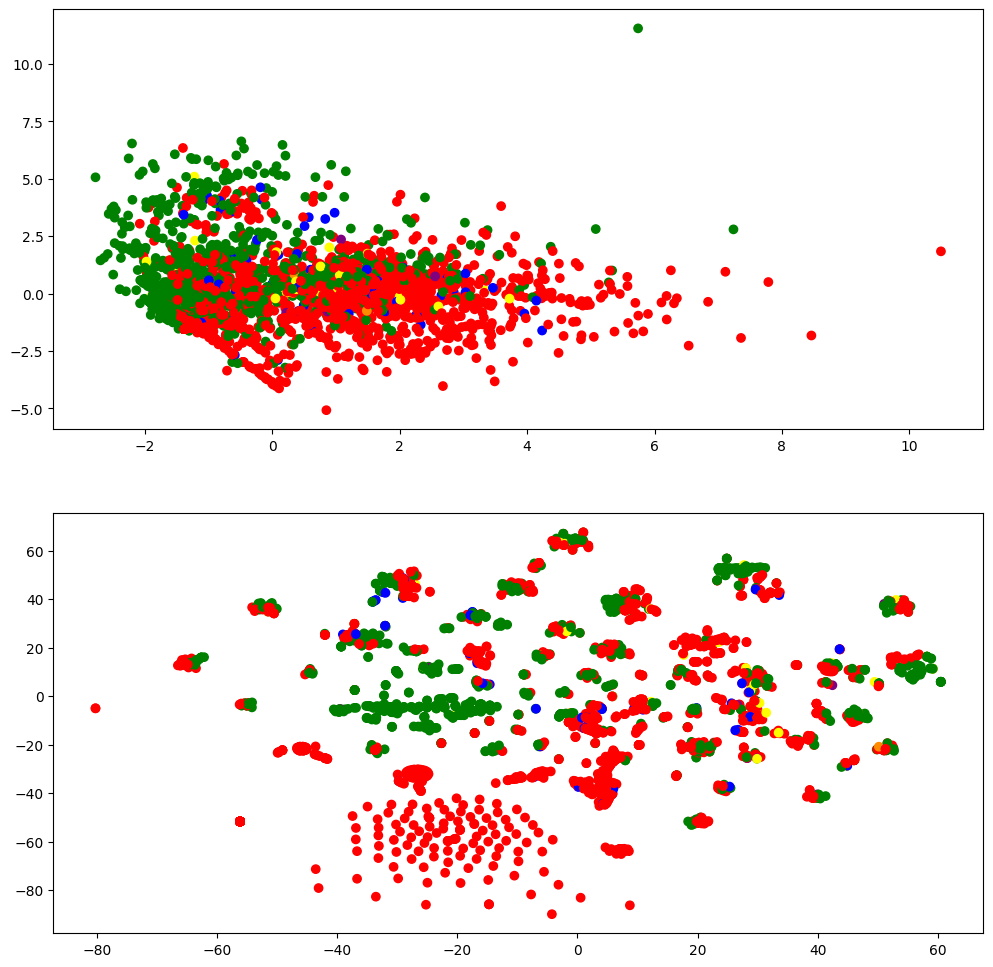

In [259]:
pca_coords = PCA(n_components=4).fit_transform(inputs)
sne_coords = TSNE(perplexity=30, n_components=2, learning_rate="auto", init='pca').fit_transform(inputs)

color_dict = {"Ended": "red", "Returning Series": "green", "Canceled": "blue", "In Production": "yellow", "Planned": "purple", "Pilot": "darkorange"}
color_vec = [color_dict[output] for output in outputs]

fig, axs = plt.subplots(2, 1)

axs[0].scatter(pca_coords[:, 0], pca_coords[:, 1], c=color_vec)
axs[1].scatter(sne_coords[:, 0], sne_coords[:, 1], c=color_vec)

plt.plot()

#### _Comments:_

- _We can see from the PCA and t-SNE graphs that the groupings are not incredibly well-defined._
- _Empirically we can see from the PCA that there are some clearer patterns for "Ended" and "Returning Series", perhaps even "Canceled", most likely because of the dates they aired._
- _We can also see several small groups appear in the t-SNE, perhaps due to the country and language variables._


---


## <center> Partie 2 : Classification </center>


---


 ### 2.1 Séparez votre jeu de données en jeux d’entrainement / validation et test.

In [260]:
inputs_train_val, inputs_test, outputs_train_val, outputs_test = train_test_split(inputs, outputs, test_size=0.3, stratify=outputs)

inputs_train_val, inputs_test, outputs_train_val, outputs_test

(array([[-0.18590874, -0.17709283, -0.09432022, ..., -0.13018891,
         -0.11771165, -0.04476615],
        [ 0.1488609 , -0.09347301, -0.09432022, ..., -0.13018891,
         -0.11771165, -0.04476615],
        [-0.18590874, -0.1436449 , -0.09432022, ..., -0.13018891,
         -0.11771165, -0.04476615],
        ...,
        [-0.18590874, -0.16873084, -0.09432022, ..., -0.13018891,
         -0.11771165, -0.04476615],
        [ 0.1488609 ,  0.09885255, -0.09432022, ..., -0.13018891,
         -0.11771165, -0.04476615],
        [-0.18590874, -0.1436449 , -0.09432022, ..., -0.13018891,
         -0.11771165, -0.04476615]]),
 array([[-0.18590874, -0.16036886, -0.09432022, ..., -0.13018891,
          8.49533588, -0.04476615],
        [-0.18590874, -0.18545481, -0.09432022, ..., -0.13018891,
         -0.11771165, -0.04476615],
        [-0.18590874, -0.02657716, -0.061104  , ..., -0.13018891,
         -0.11771165, -0.04476615],
        ...,
        [-0.18590874, -0.11019698, -0.09432022, ..., -

### 2.2 Entrainez une régression logistique multinomiale avec les paramètres par défaut.

Ce sera votre baseline. Affichez l’exactitude, la précision, le rappel, et la mesure F1 sur les jeux d’entrainement / validation et de test.

In [261]:
# I have increased the number of iterations as it reaches its limit, and since my data has multiple classes I have given it the multinomial parameter:
logistic_reg = LogisticRegression(max_iter=1000, multi_class="multinomial")
logistic_reg.fit(inputs_train_val, outputs_train_val)

outputs_log_train = logistic_reg.predict(inputs_train_val)
outputs_log_test = logistic_reg.predict(inputs_test)

accuracy_log_train_baseline = accuracy_score(outputs_train_val, outputs_log_train)
accuracy_log_test_baseline = accuracy_score(outputs_test, outputs_log_test)

# Since the target is multiclass, I have changed the average from 'binary' to 'macro' to avoid the UndefinedMetricWarning, I have added the 'zero_division' parameter to the precision score:
precision_log_train_baseline = precision_score(outputs_train_val, outputs_log_train, average="macro", zero_division=0)
precision_log_test_baseline = precision_score(outputs_test, outputs_log_test, average="macro", zero_division=0)

recall_log_train_baseline = recall_score(outputs_train_val, outputs_log_train, average="macro")
recall_log_test_baseline = recall_score(outputs_test, outputs_log_test, average="macro")

f1_log_train_baseline = f1_score(outputs_train_val, outputs_log_train, average="macro")
f1_log_test_baseline = f1_score(outputs_test, outputs_log_test, average="macro")

ami_log_train_baseline = adjusted_mutual_info_score(outputs_train_val, outputs_log_train)
ami_log_test_baseline = adjusted_mutual_info_score(outputs_test, outputs_log_test)

print('\nBASELINE:')
print(f"L'exactitude pour le modèle logistique est "f"de {accuracy_log_train_baseline:.2%} (train) {accuracy_log_test_baseline:.2%} (test).")
print(f"La précision pour le modèle logistique est "f"de {precision_log_train_baseline:.2%} (train) {precision_log_test_baseline:.2%} (test).")
print(f"Le rappel pour le modèle logistique est "f"de {recall_log_train_baseline:.2%} (train) {recall_log_test_baseline:.2%} (test).")
print(f"Le F1 pour le modèle logistique est "f"de {f1_log_train_baseline:.2%} (train) {f1_log_test_baseline:.2%} (test).")


BASELINE:
L'exactitude pour le modèle logistique est de 96.67% (train) 94.89% (test).
La précision pour le modèle logistique est de 91.96% (train) 45.09% (test).
Le rappel pour le modèle logistique est de 64.95% (train) 37.27% (test).
Le F1 pour le modèle logistique est de 73.10% (train) 38.97% (test).


### 2.3 Faites une cross-validation sur le jeux d’entrainement / validation pour un SVM.

A chaque fois, fixez 𝐶 = 5 et optimisez l’unique hyperparamètre libre 𝛾 selon l’exactitude. Affichez les courbes de l’exactitude en fonction de lx’hyperparamètre.

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[CV 1/4] END ...................C=5, gamma=0.01;, score=0.945 total time=   0.0s
[CV 2/4] END ...................C=5, gamma=0.01;, score=0.937 total time=   0.0s
[CV 3/4] END ...................C=5, gamma=0.01;, score=0.933 total time=   0.0s
[CV 4/4] END ...................C=5, gamma=0.01;, score=0.930 total time=   0.0s
[CV 1/4] END ....C=5, gamma=0.06210526315789474;, score=0.897 total time=   0.1s
[CV 2/4] END ....C=5, gamma=0.06210526315789474;, score=0.855 total time=   0.1s
[CV 3/4] END ....C=5, gamma=0.06210526315789474;, score=0.891 total time=   0.1s
[CV 4/4] END ....C=5, gamma=0.06210526315789474;, score=0.884 total time=   0.1s
[CV 1/4] END ....C=5, gamma=0.11421052631578947;, score=0.869 total time=   0.2s
[CV 2/4] END ....C=5, gamma=0.11421052631578947;, score=0.829 total time=   0.2s
[CV 3/4] END ....C=5, gamma=0.11421052631578947;, score=0.870 total time=   0.2s
[CV 4/4] END ....C=5, gamma=0.11421052631578947;

[]

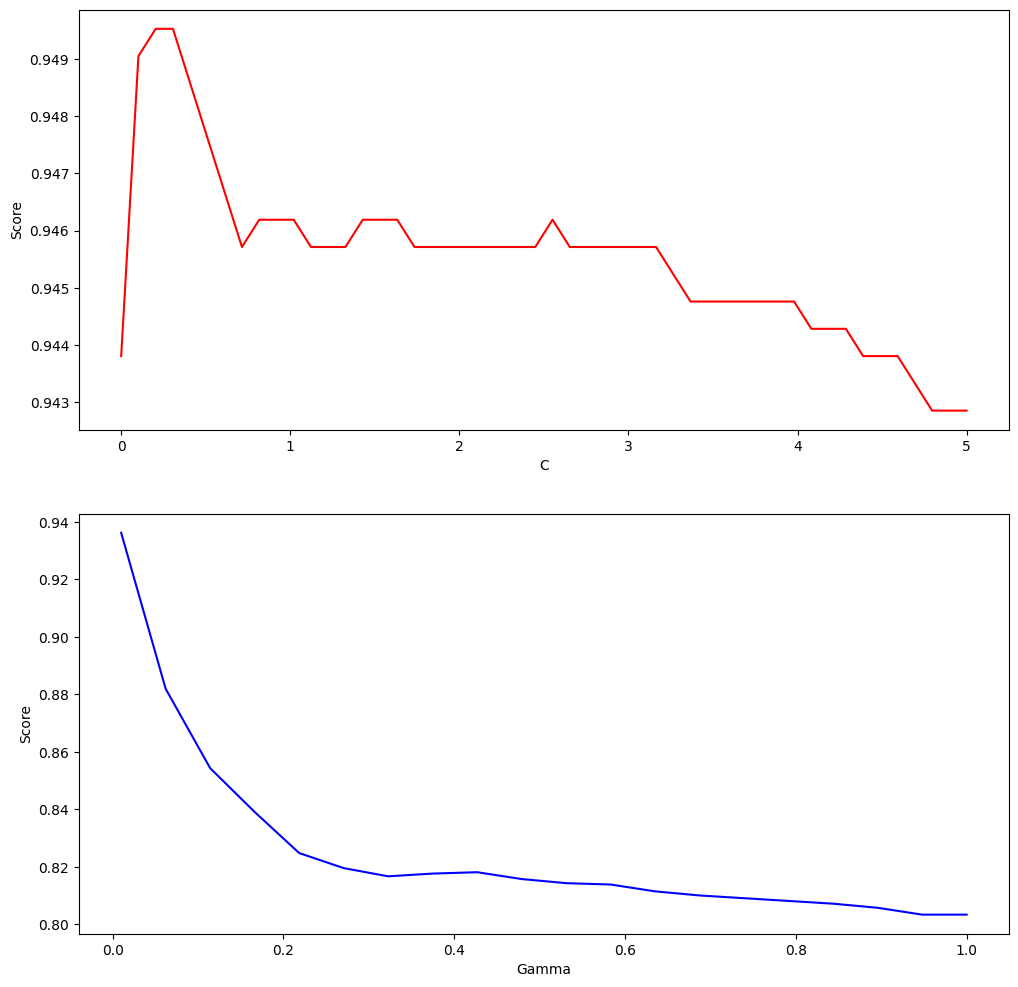

In [262]:
# It is possible I misunderstood this section!

# 1. Optimized logistic regression:

k = 4
params = np.linspace(0.001, 5, 50)
param_dict = {"C": params}

# Optimizing hyperparameter according to accuracy:
grid_search = GridSearchCV(logistic_reg, param_dict, cv=k, scoring="accuracy", refit="accuracy")
grid_search.fit(inputs_train_val, outputs_train_val)

accuracy_scores = grid_search.cv_results_["mean_test_score"]

# 2. SVM:

c_par = [5]
gamma_par = np.linspace(0.01, 1, 20)
param_dict = {"C": c_par, "gamma": gamma_par}

svm_classifier = SVC()

grid_search_svm = RandomizedSearchCV(svm_classifier, param_dict, n_iter=20, cv=k, scoring="accuracy", verbose=4, refit="accuracy")
grid_search_svm.fit(inputs_train_val, outputs_train_val)

gamma_values = grid_search_svm.cv_results_['param_gamma']
accuracy_scores_svm = grid_search_svm.cv_results_["mean_test_score"]

fig, axs = plt.subplots(2, 1)

axs[0].plot(params, accuracy_scores, c="red")
axs[0].set_xlabel("C")
axs[0].set_ylabel("Score")

axs[1].plot(gamma_values, accuracy_scores_svm, c="blue")
axs[1].set_xlabel('Gamma')
axs[1].set_ylabel('Score')

plt.plot()


### 2.4 Retenez le meilleur modèle selon l’exactitude et comparez avec la baseline son exactitude, sa précision, son rappel, et sa mesure F1, sur les jeux d’entrainement / validation et de test.

Commentez.

In [266]:
# 1. Optimized logistic regression:

index_best_accuracy = np.where(accuracy_scores == max(accuracy_scores))[0][0]

best_accuracy_par = params[index_best_accuracy]
best_accuracy_log_reg = LogisticRegression(C=best_accuracy_par, max_iter=1000)
best_accuracy_log_reg.fit(inputs_train_val, outputs_train_val)

outputs_log_train_best = best_accuracy_log_reg.predict(inputs_train_val)
outputs_log_test_best = best_accuracy_log_reg.predict(inputs_test)

accuracy_log_train_best = accuracy_score(outputs_train_val, outputs_log_train_best)
accuracy_log_test_best = accuracy_score(outputs_test, outputs_log_test_best)

precision_log_train_best = precision_score(outputs_train_val, outputs_log_train_best, average="macro", zero_division=0)
precision_log_test_best = precision_score(outputs_test, outputs_log_test_best, average="macro", zero_division=0)

recall_log_train_best = recall_score(outputs_train_val, outputs_log_train_best, average="macro")
recall_log_test_best = recall_score(outputs_test, outputs_log_test_best, average="macro")

f1_log_train_best = f1_score(outputs_train_val, outputs_log_train_best, average="macro")
f1_log_test_best = f1_score(outputs_test, outputs_log_test_best, average="macro")

ami_log_train_best = adjusted_mutual_info_score(outputs_train_val, outputs_log_train_best)
ami_log_test_best = adjusted_mutual_info_score(outputs_test, outputs_log_test_best)

# 2. SVM:

outputs_log_train_svm = grid_search_svm.predict(inputs_train_val)
outputs_log_test_svm = grid_search_svm.predict(inputs_test)

accuracy_log_train_svm = accuracy_score(outputs_train_val, outputs_log_train_svm)
accuracy_log_test_svm = accuracy_score(outputs_test, outputs_log_test_svm)

precision_log_train_svm = precision_score(outputs_train_val, outputs_log_train_svm, average="macro", zero_division=0)
precision_log_test_svm = precision_score(outputs_test, outputs_log_test_svm, average="macro", zero_division=0)

recall_log_train_svm = recall_score(outputs_train_val, outputs_log_train_svm, average="macro")
recall_log_test_svm = recall_score(outputs_test, outputs_log_test_svm, average="macro")

f1_log_train_svm = f1_score(outputs_train_val, outputs_log_train_svm, average="macro")
f1_log_test_svm = f1_score(outputs_test, outputs_log_test_svm, average="macro")

ami_log_train_svm = adjusted_mutual_info_score(outputs_train_val, outputs_log_train_svm)
ami_log_test_svm = adjusted_mutual_info_score(outputs_test, outputs_log_test_svm)

print('\nBASELINE:')
print(f"L'exactitude pour le baseline est "f"de {accuracy_log_train_baseline:.2%} (train) {accuracy_log_test_baseline:.2%} (test).")
print(f"La précision pour le baseline est "f"de {precision_log_train_baseline:.2%} (train) {precision_log_test_baseline:.2%} (test).")
print(f"Le rappel pour le baseline est "f"de {recall_log_train_baseline:.2%} (train) {recall_log_test_baseline:.2%} (test).")
print(f"Le F1 pour le modèle logistique est "f"de {f1_log_train_baseline:.2%} (train) {f1_log_test_baseline:.2%} (test).")

print(F'\nLE MEILLEUR MODELE LOGISTIQUE (OPTIMISE):')
print(f"L'exactitude pour le modèle logistique optimisé (C={best_accuracy_par:.4f}) est "f"de {accuracy_log_train_best:.2%} (train) {accuracy_log_test_best:.2%} (test).")
print(f"La précision pour le modèle logistique optimisé (C={best_accuracy_par:.4f}) est "f"de {precision_log_train_best:.2%} (train) {precision_log_test_best:.2%} (test).")
print(f"Le rappel pour le modèle logistique optimisé (C={best_accuracy_par:.4f}) est "f"de {recall_log_train_best:.2%} (train) {recall_log_test_best:.2%} (test).")
print(f"Le F1 pour le modèle logistique optimisé (C={best_accuracy_par:.4f}) est "f"de {f1_log_train_best:.2%} (train) {f1_log_test_best:.2%} (test).")

print('\nLE SVM:')
print(f"L'exactitude pour le SVM (C=5) est "f"de {accuracy_log_train_svm:.2%} (train) {accuracy_log_test_svm:.2%} (test).")
print(f"La précision pour le SVM (C=5) est "f"de {precision_log_train_svm:.2%} (train) {precision_log_test_svm:.2%} (test).")
print(f"Le rappel pour le SVM (C=5) est "f"de {recall_log_train_svm:.2%} (train) {recall_log_test_svm:.2%} (test).")
print(f"Le F1 pour le SVM (C=5) est "f"de {f1_log_train_svm:.2%} (train) {f1_log_test_svm:.2%} (test).")


BASELINE:
L'exactitude pour le baseline est de 96.67% (train) 94.89% (test).
La précision pour le baseline est de 91.96% (train) 45.09% (test).
Le rappel pour le baseline est de 64.95% (train) 37.27% (test).
Le F1 pour le modèle logistique est de 73.10% (train) 38.97% (test).

LE MEILLEUR MODELE LOGISTIQUE (OPTIMISE):
L'exactitude pour le modèle logistique optimisé (C=0.2050) est de 96.33% (train) 95.56% (test).
La précision pour le modèle logistique optimisé (C=0.2050) est de 75.06% (train) 54.16% (test).
Le rappel pour le modèle logistique optimisé (C=0.2050) est de 53.29% (train) 35.43% (test).
Le F1 pour le modèle logistique optimisé (C=0.2050) est de 59.15% (train) 36.55% (test).

LE SVM:
L'exactitude pour le SVM (C=5) est de 96.90% (train) 94.11% (test).
La précision pour le SVM (C=5) est de 98.99% (train) 62.28% (test).
Le rappel pour le SVM (C=5) est de 54.92% (train) 38.07% (test).
Le F1 pour le SVM (C=5) est de 64.62% (train) 40.95% (test).


#### _Comments:_

- _We can see that the optimized logistic regression model has lower accuracy than our baseline; it generally performs worse on the training set and better on the test set; the SVM has higher accuracy than both the baseline and the optimized logistic regression model for training, and lower accuracy for testing._
- _The precision for the optimized logistic regression model is generally lower than the baseline in terms of the training set but higher for the test set; the precision of the SVM is higher than both for the training set and lower for the test test._
- _The optimized logistic regression model has lower recall for training and testing than the baseline; the SVM has lower recall for the training set than the baseline, and lower recall than the optimized model for the test set._
- _The optimized logistic regression model has a lower F1 score for training and testing; the SVM too._
- _So we can see that the optimized logistic model performs better when it comes to the test set, and the SVM less well, whereas the baseline performs better on the training set._


---


## <center> Partie 3 : Clustering </center>


---


### 3.1 Effectuez un clustering hiérarchique agglomératif en fonction du nombre de groupes, puis tracez la courbe du score Calinski-Harabasz en fonction de 𝑘.

Quelle est la valeur du nombre de groupes à retenir ?

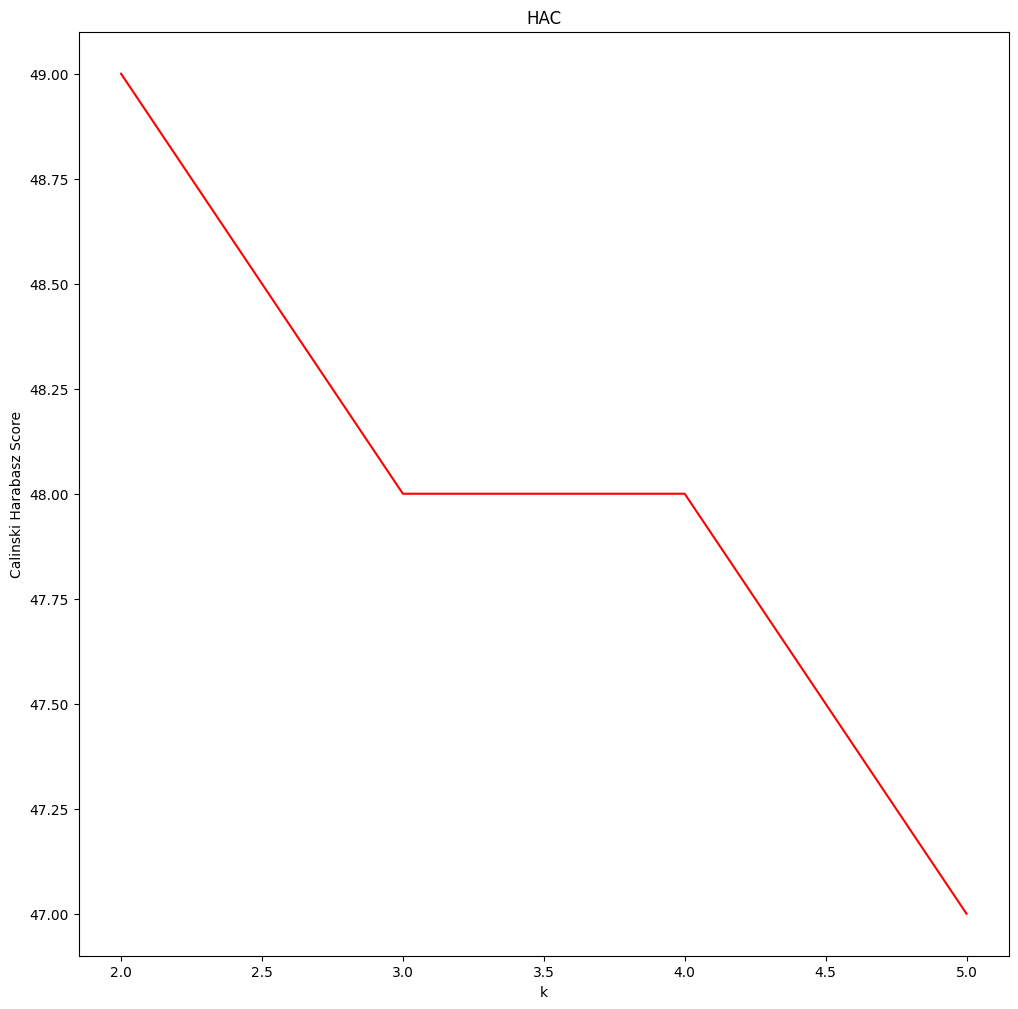

In [268]:
def inertia_score(X, labels):
  groups = set(labels)
  sq_residuals = np.repeat(0, X.shape[0])
  for group in groups:
    X_g = np.array(X)[labels == group, :]
    std_scale = StandardScaler(with_std=False)
    sq_residuals_g = (std_scale.fit_transform(X_g)**2).sum(axis=1)
    sq_residuals[labels == group] = sq_residuals_g
  return sum(sq_residuals)

# I have chosen a smaller range here for simplicity since I was having problems with the GMM which was highly volatile at higher values of k:
k_pars = list(range(2, 6))
n_test = 5

hac_in_mscores, hac_ch_mscores = np.zeros_like(k_pars), np.zeros_like(k_pars)
hac_in_sscores, hac_ch_sscores = np.zeros_like(k_pars), np.zeros_like(k_pars)

gmm_in_mscores, gmm_ch_mscores = np.zeros_like(k_pars), np.zeros_like(k_pars)
gmm_in_sscores, gmm_ch_sscores = np.zeros_like(k_pars), np.zeros_like(k_pars)

for i, k in enumerate(k_pars):
  hac_in_scores, hac_ch_scores = np.zeros(n_test), np.zeros(n_test)
  gmm_in_scores, gmm_ch_scores = np.zeros(n_test), np.zeros(n_test)
  for j in range(n_test):
    hac_labels = AgglomerativeClustering(n_clusters=k).fit_predict(inputs)
    gmm_labels = GaussianMixture(n_components=k).fit_predict(inputs)
    hac_in_scores[j] = inertia_score(inputs, hac_labels)
    hac_ch_scores[j] = calinski_harabasz_score(inputs, hac_labels)
    gmm_in_scores[j] = inertia_score(inputs, gmm_labels)
    gmm_ch_scores[j] = calinski_harabasz_score(inputs, gmm_labels)
  hac_in_mscores[i] = np.mean(hac_in_scores)
  gmm_in_mscores[i] = np.mean(gmm_in_scores)
  hac_ch_mscores[i] = np.mean(hac_ch_scores)
  gmm_ch_mscores[i] = np.mean(gmm_ch_scores)
  hac_in_sscores[i] = np.std(hac_in_scores)
  gmm_in_sscores[i] = np.std(gmm_in_scores)
  hac_ch_sscores[i] = np.std(hac_ch_scores)
  gmm_ch_sscores[i] = np.std(gmm_ch_scores)

fig, ax = plt.subplots()

ax.plot(k_pars, hac_ch_mscores, c="red")

ax.set_xlabel("k")
ax.set_ylabel("Calinski Harabasz Score")
ax.set_title("HAC")

plt.plot()

# Based on the following graphic, the number of groups to maintain is 3 (sometimes 4):
hac_best_k = 3

### 3.2 Tracez la courbe du score Calinski-Harabasz pour un GMM en fonction de 𝑘 et répondez à la même question.

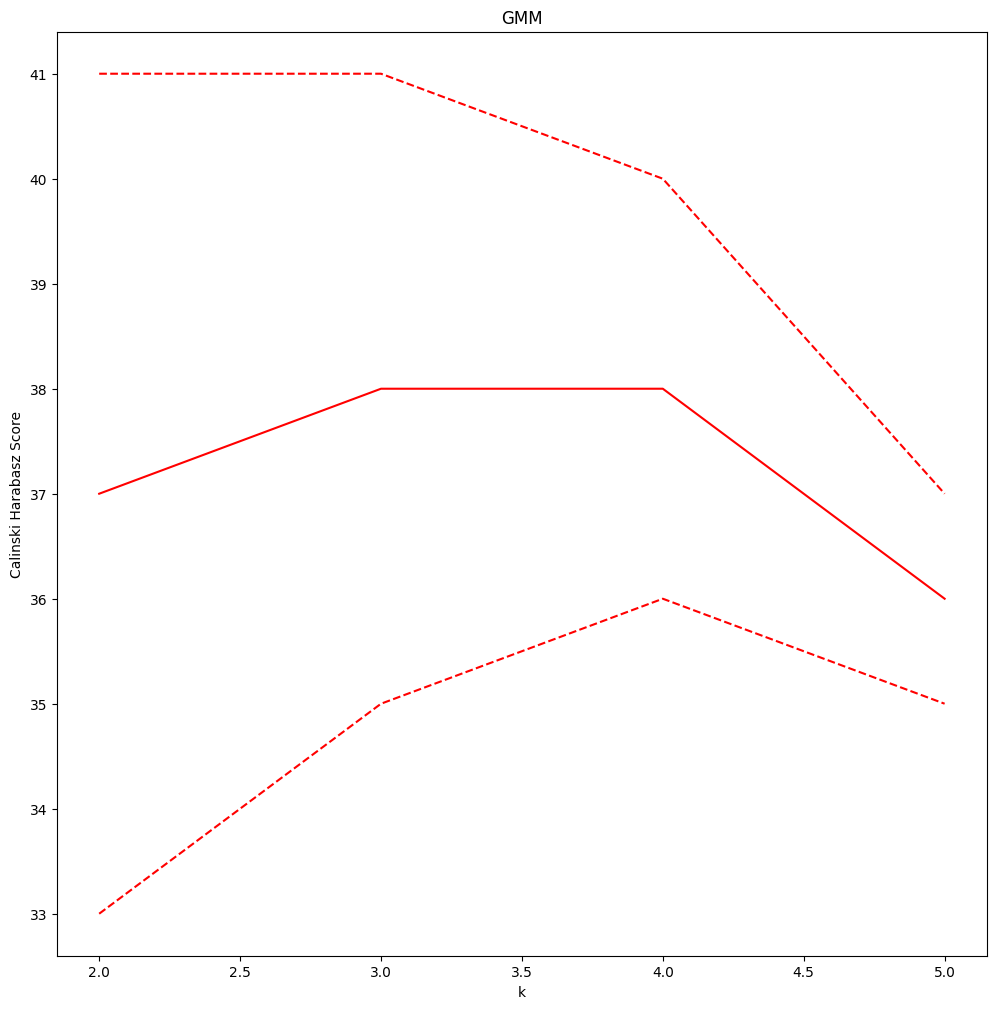

In [269]:
fig, ax = plt.subplots()

ax.plot(k_pars, gmm_ch_mscores, c="red")
ax.plot(k_pars, gmm_ch_mscores + gmm_ch_sscores, c="red", linestyle = "--")
ax.plot(k_pars, gmm_ch_mscores - gmm_ch_sscores, c="red", linestyle = "--")

ax.set_xlabel("k")
ax.set_ylabel("Calinski Harabasz Score")
ax.set_title("GMM")

plt.plot()

# Based on the following graphic, the number of groups to maintain is 3, although sometimes it is 4 since it is highly variable:
gmm_best_k = 3


### 3.3 Pour les modèle retenus, calculez le AMI, l’homogénéité et la complétude par rapport aux vraies données.

Commentez.

In [270]:
hac_labels = AgglomerativeClustering(n_clusters=hac_best_k).fit_predict(inputs)
gmm_labels = GaussianMixture(n_components=gmm_best_k).fit_predict(inputs)

hac_ari = adjusted_rand_score(outputs, hac_labels)
gmm_ari = adjusted_rand_score(outputs, gmm_labels)

hac_ami = adjusted_mutual_info_score(outputs, hac_labels)
gmm_ami = adjusted_mutual_info_score(outputs, gmm_labels)

hac_homog = homogeneity_score(outputs, hac_labels)
gmm_homog = homogeneity_score(outputs, gmm_labels)

hac_comp = completeness_score(outputs, hac_labels)
gmm_comp = completeness_score(outputs, gmm_labels)

print(f"\nHAC (k={hac_best_k}):\n ARI = {hac_ari: .2%}, "f"AMI = {hac_ami: .2%}, Homogeneity ={hac_homog: .2%}, "f"Completeness ={hac_comp: .2%}.")

print(f"\nGMM (k={gmm_best_k}):\n ARI = {gmm_ari: .2%}, "f"AMI = {gmm_ami: .2%}, Homogeneity ={gmm_homog: .2%}, "f"Completeness ={gmm_comp: .2%}.")



HAC (k=3):
 ARI =  2.85%, AMI =  3.12%, Homogeneity = 3.49%, Completeness = 3.14%.

GMM (k=3):
 ARI = -0.52%, AMI =  0.58%, Homogeneity = 0.63%, Completeness = 1.10%.


#### _Comments:_

- _The HAC is not very effective; the ARI is low and the AMI close to zero so it is of similar success to a random clustering; the homogeneity is also low as is completeness._
- _The GMM is not very effective either; the ARI is negative, the AMI is close to zero, but homogeneity and completeness are uninspiring._

### 3.4 Choisissez entre la méthode CAH ou GMM en fonction du meilleur AMI. En utilisant cette fois-ci le bon nombre de groupes et en utilisant toutes les données, comparez le AMI obtenu avec cette méthode, le AMI obtenu avec la régression logistique multinomiale, et le AMI obtenu avec la méthode de classification retenue au point 2.4.

Commentez.

In [271]:
print(f"\nHAC (k={hac_best_k}):\n AMI ={hac_ami: .2%}.")

print(f"\nGMM (k={gmm_best_k}):\n AMI ={gmm_ami: .2%}.")

print(f"\nRégression logistique multinomiale:\n AMI (train) ={ami_log_train_baseline: .2%}, AMI (test) ={ami_log_test_baseline: .2%}.")

print(f"\nRégression logistique multinomiale optimisée (k=4):\n AMI (train) ={ami_log_train_best: .2%}, AMI (test) ={ami_log_test_best: .2%}.")

print(f"\nSVM (C=5):\n AMI (train) ={ami_log_train_svm: .2%}, AMI (test) ={ami_log_test_svm: .2%}.")



HAC (k=3):
 AMI = 3.12%.

GMM (k=3):
 AMI = 0.58%.

Régression logistique multinomiale:
 AMI (train) = 88.37%, AMI (test) = 83.24%.

Régression logistique multinomiale optimisée (k=4):
 AMI (train) = 87.68%, AMI (test) = 86.19%.

SVM (C=5):
 AMI (train) = 88.76%, AMI (test) = 74.64%.


#### _Comments:_

- _The AMI scores for the HAC and GMM are terrible in comparison to those for the multinomial logistic regression, optimized logistic regression and SVM._
- _The multinomial logistic regression, optimized logistic regression and the SVM all have a better AMI score for the training set than for the test set._
- _Clustering is less successful overall._


---


## <center> Partie 4 : Méthode mixte </center>


---


### 4.1 Reprenez les 2 premières coordonnées des points obtenues par la PCA ou du t-SNE en fonction de l’affichage permettant de distinguer au mieux les classes à prédire.

Vous allez maintenant utiliser ces deux variables comme entrées pour prédire la variable catégorielle retenue.

In [272]:
sne_coords[:, 0]
sne_coords[:, 1]

array([ 35.969376, -42.161686,  16.47427 , ...,  32.952908,  38.140087,
        36.53064 ], dtype=float32)

### 4.2 Sélectionnez une des méthodes utilisées précédemment, celle qui vous semble la plus prometteuse mis à part le clustering agglomératif.

In [273]:
logistic_reg = LogisticRegression(max_iter=1000, multi_class="multinomial")

logistic_reg

LogisticRegression(max_iter=1000, multi_class='multinomial')

### 4.3 Séparez votre jeu de données en entrainement / validation et test, effectuez une recherche sur grille s’il y a des hyperparamètres à optimiser, puis comparer avec les résultats précédemment obtenus.

Commentez.

In [274]:
inputs_train_val, inputs_test, outputs_train_val, outputs_test \
  = train_test_split(sne_coords[:, :2], outputs, test_size=0.3, stratify=outputs)

logistic_reg.fit(inputs_train_val, outputs_train_val)

outputs_log_train = logistic_reg.predict(inputs_train_val)
outputs_log_test = logistic_reg.predict(inputs_test)

accuracy_log_train_mix = accuracy_score(outputs_train_val, outputs_log_train)
accuracy_log_test_mix = accuracy_score(outputs_test, outputs_log_test)

precision_log_train_mix = precision_score(outputs_train_val, outputs_log_train, average="macro", zero_division=0)
precision_log_test_mix = precision_score(outputs_test, outputs_log_test, average="macro", zero_division=0)

recall_log_train_mix = recall_score(outputs_train_val, outputs_log_train, average="macro")
recall_log_test_mix = recall_score(outputs_test, outputs_log_test, average="macro")

f1_log_train_mix = f1_score(outputs_train_val, outputs_log_train, average="macro")
f1_log_test_mix = f1_score(outputs_test, outputs_log_test, average="macro")

print('\nRESULTATS PRECEDENTS (BASELINE):')
print(f"L'exactitude pour le modèle logistique est "f"de {accuracy_log_train_baseline:.2%} (train) {accuracy_log_test_baseline:.2%} (test).")
print(f"La précision pour le modèle logistique est "f"de {precision_log_train_baseline:.2%} (train) {precision_log_test_baseline:.2%} (test).")
print(f"Le rappel pour le modèle logistique est "f"de {recall_log_train_baseline:.2%} (train) {recall_log_test_baseline:.2%} (test).")
print(f"Le F1 pour le modèle logistique est "f"de {f1_log_train_baseline:.2%} (train) {f1_log_test_baseline:.2%} (test).")

print('\nCOMPARAISON (MIXTE):')
print(f"L'exactitude pour ce modèle logistique est "f"de {accuracy_log_train_mix:.2%} (train) {accuracy_log_test_mix:.2%} (test).")
print(f"La précision pour ce modèle logistique est "f"de {precision_log_train_mix:.2%} (train) {precision_log_test_mix:.2%} (test).")
print(f"Le rappel pour ce modèle logistique est "f"de {recall_log_train_mix:.2%} (train) {recall_log_test_mix:.2%} (test).")
print(f"Le F1 pour ce modèle logistique est "f"de {f1_log_train_mix:.2%} (train) {f1_log_test_mix:.2%} (test).")



RESULTATS PRECEDENTS (BASELINE):
L'exactitude pour le modèle logistique est de 96.67% (train) 94.89% (test).
La précision pour le modèle logistique est de 91.96% (train) 45.09% (test).
Le rappel pour le modèle logistique est de 64.95% (train) 37.27% (test).
Le F1 pour le modèle logistique est de 73.10% (train) 38.97% (test).

COMPARAISON (MIXTE):
L'exactitude pour ce modèle logistique est de 58.67% (train) 60.89% (test).
La précision pour ce modèle logistique est de 18.43% (train) 19.45% (test).
Le rappel pour ce modèle logistique est de 18.82% (train) 19.42% (test).
Le F1 pour ce modèle logistique est de 18.19% (train) 18.75% (test).


#### _Comments:_

- _This mixed method has a much lesser performance compared to our previous results and baseline._
- _The accuracy, precision, recall and F1 score are all much less significant for the mixed method than for the previous results from the logistic regression models and SVM._
- _In contrast, the mixed method generally has better accuracy, precision, recall and F1 scores for the test set than for the training set._

### 4.4 Tracez les frontières de décision de la méthode sélectionnée ainsi que les individus en fonction des deux coordonnées d’entrée.

[]

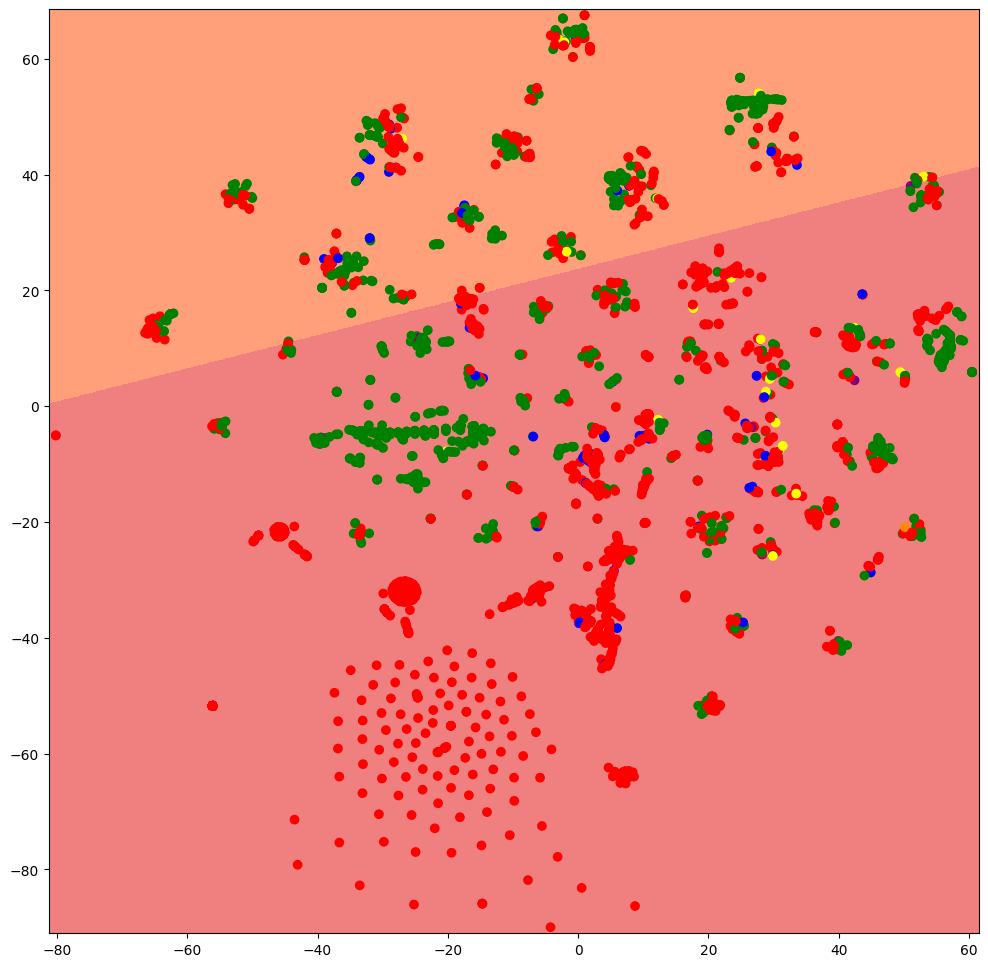

In [275]:
mesh_cmap = ListedColormap(["lightcoral", "lightgreen", "lightblue", "lightyellow", "lavender", "lightsalmon"])
points_cmap = ListedColormap(["red", "green", "blue", "yellow", "purple", "darkorange"])

mesh_size = 0.1

outputs_num = outputs.replace(["Ended", "Returning Series", "Canceled", "In Production", "Planned", "Pilot"], [0, 1, 2, 3, 4, 5])

x_min, x_max = sne_coords[:, 0].min() - 1, sne_coords[:, 0].max() + 1
y_min, y_max = sne_coords[:, 1].min() - 1, sne_coords[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_size),
                      np.arange(y_min, y_max, mesh_size))

grid_pred = logistic_reg.predict(np.c_[xx.ravel(), yy.ravel()])

grid_pred_num = pd.Series(grid_pred).replace(["Ended", "Returning Series", "Canceled", "In Production", "Planned", "Pilot"], [0, 1, 2, 3, 4, 5])
grid_pred_num = grid_pred_num.to_numpy().reshape(xx.shape)

fig, ax = plt.subplots()

ax.pcolormesh(xx, yy, grid_pred_num, cmap=mesh_cmap)

ax.scatter(sne_coords[:, 0], sne_coords[:, 1], c=outputs_num, cmap=points_cmap)

plt.plot()

### 4.5 Sauvegardez le meilleur modèle.

In [277]:
index_best_mix_accuracy = np.where(accuracy_scores == max(accuracy_scores))[0][0]

best_mix_accuracy_par = params[index_best_mix_accuracy]
best_mix_accuracy_log_reg = LogisticRegression(C=best_mix_accuracy_par, max_iter=1000)
best_mix_accuracy_log_reg.fit(inputs_train_val, outputs_train_val)

model_path = "saved_model.sav"

# Saving all of the attributes and parameters associated with the best logistic regression model to an external file:
with open(model_path, "wb") as file_out:
  pickle.dump({"model": best_mix_accuracy_log_reg, "coef": best_mix_accuracy_log_reg.coef_, "intercept": best_mix_accuracy_log_reg.intercept_, "classes": best_mix_accuracy_log_reg.classes_, "params": best_mix_accuracy_log_reg.get_params()}, file_out)

with open(model_path, "rb") as file_in:
  best_model = pickle.load(file_in)

best_model

{'model': LogisticRegression(C=0.2050408163265306, max_iter=1000),
 'coef': array([[-0.01328842,  0.0049043 ],
        [-0.0051462 , -0.01039481],
        [ 0.0034228 ,  0.01834688],
        [ 0.02528433, -0.02222652],
        [ 0.00065363, -0.00039232],
        [-0.01092615,  0.00976247]]),
 'intercept': array([ 0.12628501,  3.16095339, -1.00608921, -3.08843199, -1.87507316,
         2.68235596]),
 'classes': array(['Canceled', 'Ended', 'In Production', 'Pilot', 'Planned',
        'Returning Series'], dtype=object),
 'params': {'C': 0.2050408163265306,
  'class_weight': None,
  'dual': False,
  'fit_intercept': True,
  'intercept_scaling': 1,
  'l1_ratio': None,
  'max_iter': 1000,
  'multi_class': 'auto',
  'n_jobs': None,
  'penalty': 'l2',
  'random_state': None,
  'solver': 'lbfgs',
  'tol': 0.0001,
  'verbose': 0,
  'warm_start': False}}


---
---
